In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import warnings
import plotly.express as px
import plotly.graph_objects as go
import ast
from scipy.stats import f_oneway

In [50]:
warnings.filterwarnings("ignore", category=FutureWarning)

SAVE_PATH_WAVES = "../c1n3mada-datastory/assets/plots/waves/"

# load dataset

df_season = pd.read_csv("data/processed/movies_processed.csv")

# define seasons

def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return np.nan  # Handle missing or invalid months


df_season["release_month"] = pd.to_datetime(
    df_season["movie_release_date"], errors="coerce"
).dt.month
df_season["season"] = df_season["release_month"].apply(assign_season)

# Drop rows with missing revenue or runtime
df_season = df_season.dropna(subset=["inflated_revenue", "movie_runtime"])

# convert genres into lists of strings

df_season["inflated_revenue"] = pd.to_numeric(
    df_season["inflated_revenue"]
)
df_season["movie_runtime"] = pd.to_numeric(df_season["movie_runtime"])


In [51]:
# Plot: Distribution of Movie Revenues

fig_hist = px.histogram(
    df_season,
    x="inflated_revenue",
    nbins=50,
    title="Distribution of Movie Revenues",
    labels={"inflated_revenue": "Revenue"},
    color_discrete_sequence=px.colors.colorbrewer.Set2
)
fig_hist.update_layout(
    xaxis_title="Revenue (USD)",
    yaxis_title="Count of Movies",
    title_x=0.5
)

fig_hist.show()
fig_hist.write_html(
    f"{SAVE_PATH_WAVES}revenue_distribution.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "revenue_distribution"}},
)


In [52]:
# Plot: Average Movie Revenue by Season

season_revenue = df_season.groupby("season", as_index=False)["inflated_revenue"].mean()

fig_season_bar = px.bar(
    season_revenue,
    x="season",
    y="inflated_revenue",
    title="Average Movie Box Office Revenue by Season",
    labels={"season": "Season", "inflated_revenue": "Average Revenue [$]"},
    color="season",
    color_discrete_sequence=px.colors.colorbrewer.Set2
)

fig_season_bar.update_layout(
    title_x=0.5, 
    template="plotly_white",
    title_font=dict(family="Arial"),
    showlegend=False,
    margin=dict(t=70, b=50, l=50, r=50),  
    title=dict(pad=dict(t=10, b=0)),
)

fig_season_bar.show()
fig_season_bar.write_html(
    f"{SAVE_PATH_WAVES}season_revenue_bar.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "season_revenue_bar"}},
)

In [54]:
# Plot: Movie Runtime vs Revenue by Season

fig_runtime_scatter = px.scatter(
    df_season,
    x="movie_runtime",
    y="inflated_revenue",
    color="season",
    title="Relation Between Movie Runtime and Revenue by Season",
    labels={"movie_runtime": "Runtime [min]", "inflated_revenue": "Revenue [$]"},
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data=["movie_name", "season"]
)

for s in df_season["season"].unique():
    subset = df_season[df_season["season"] == s]
    # Fit a simple linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset["movie_runtime"], subset["inflated_revenue"])
    x_vals = np.linspace(subset["movie_runtime"].min(), subset["movie_runtime"].max(), 100)
    y_vals = intercept + slope * x_vals
    fig_runtime_scatter.add_trace(go.Scatter(x=x_vals, y=y_vals, mode='lines', name=f"{s} Trend", line=dict(dash='dash')))

fig_runtime_scatter.update_layout(
    title_x=0.5,
    template="plotly_white",
    title_font=dict(family="Arial"),
    showlegend=True,
    margin=dict(t=70, b=50, l=50, r=50),  
    title=dict(pad=dict(t=10, b=0)),
    legend_title=dict(text="Season") 
)

fig_runtime_scatter.show()
fig_runtime_scatter.write_html(
    f"{SAVE_PATH_WAVES}runtime_revenue_scatter.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "runtime_revenue_scatter"}},
)

In [21]:
# Genre Analysis

df_genres_and_season = df_season.copy()
df_genres_and_season = df_genres_and_season[
    df_genres_and_season["movie_genres"].notna()
]
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    ast.literal_eval
)
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)
df_genres_and_season = df_genres_and_season.explode("movie_genres")
genre_revenue = df_genres_and_season.groupby("movie_genres", as_index=False)["inflated_revenue"].mean()
top_genres = genre_revenue.sort_values("inflated_revenue", ascending=False).head(10)
genre_revenue = (
    df_genres_and_season.groupby("movie_genres")["inflated_revenue"]
    .mean()
    .reset_index()
)
top_genres = genre_revenue.sort_values(
    "inflated_revenue", ascending=False
).head(10)

In [24]:
# Plot: Genre Popularity Over Time

genre_year = (
    df_genres_and_season.groupby(["movie_genres", "release_year"])
    .size()
    .reset_index(name="count")
)

genre_year_pivot = genre_year.pivot_table(
    values="count", index="movie_genres", columns="release_year", fill_value=0
)

top_genres_list = (
    df_genres_and_season["movie_genres"].value_counts().head(10).index.tolist()
)
genre_year_pivot = genre_year_pivot.loc[top_genres_list]

fig = px.imshow(
    genre_year_pivot,
    labels=dict(x="Release Year", y="Genre", color="Number of Movies"),
    x=genre_year_pivot.columns,
    y=genre_year_pivot.index,
    color_continuous_scale="viridis_r"
)

fig.update_layout(
    xaxis_title="Release Year",
    yaxis_title="Genre",
    title_x=0.5,
    template="plotly_white",
    margin=dict(t=70, b=50, l=50, r=50),  #
    title=dict(text="Genre Popularity Over Time", pad=dict(t=10, b=0)),
    title_font=dict(family="Arial"),
)

fig.show()
fig.write_html(
    f"{SAVE_PATH_WAVES}genre_popularity_over_time.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "genre_popularity_over_time"}},
)


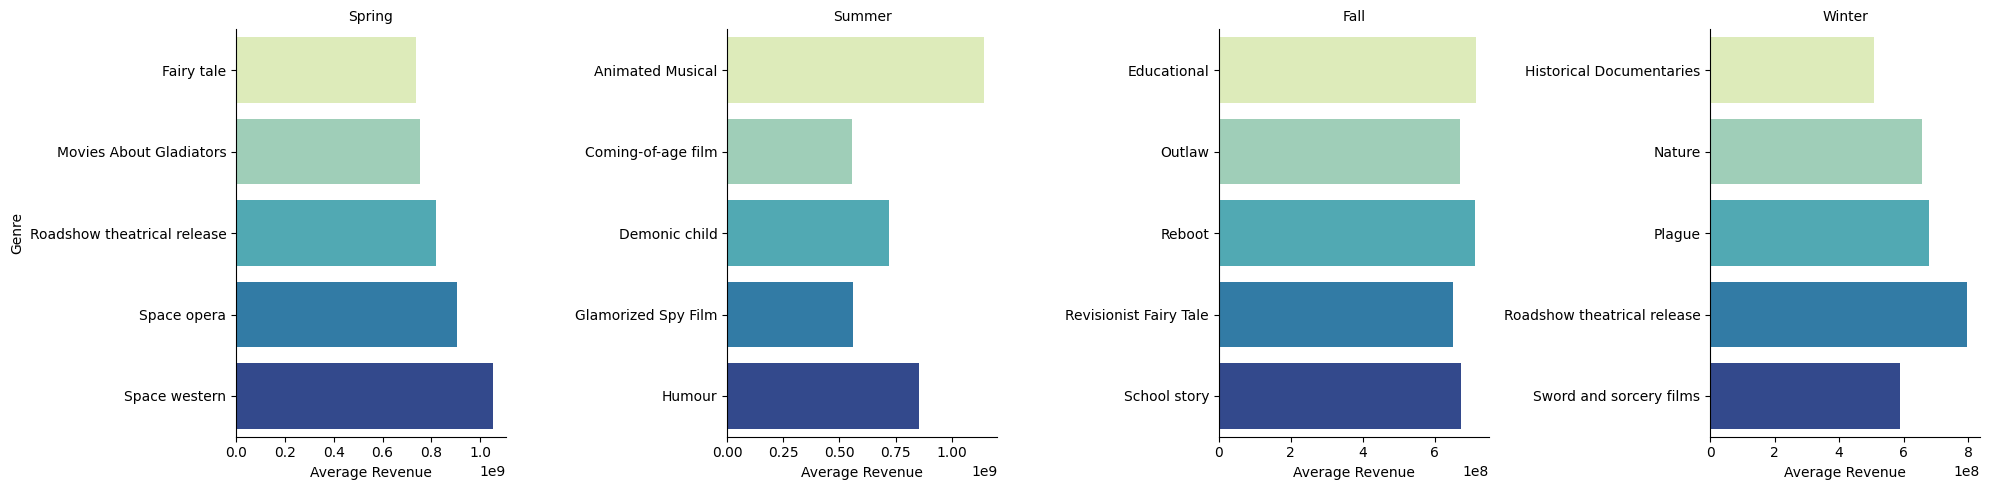

In [25]:
# Additional calculations

df_genres_season = df_genres_and_season.dropna(
    subset=["season", "inflated_revenue"]
)

genre_season_revenue = (
    df_genres_season.groupby(["season", "movie_genres"])["inflated_revenue"]
    .mean()
    .reset_index()
)

top_n = 5 
top_genres_per_season = {}
for season in genre_season_revenue["season"].unique():
    top_genres = (
        genre_season_revenue[genre_season_revenue["season"] == season]
        .sort_values("inflated_revenue", ascending=False)
        .head(top_n)["movie_genres"]
        .tolist()
    )
    top_genres_per_season[season] = top_genres

filtered_genre_season_revenue = pd.DataFrame()
for season in top_genres_per_season:
    top_genres = top_genres_per_season[season]
    temp_df = genre_season_revenue[
        (genre_season_revenue["season"] == season)
        & (genre_season_revenue["movie_genres"].isin(top_genres))
    ]
    filtered_genre_season_revenue = pd.concat(
        [filtered_genre_season_revenue, temp_df], ignore_index=True
    )

filtered_genre_season_revenue.rename(
    columns={
        "movie_genres": "Genre",
        "inflated_revenue": "Average Revenue",
        "season": "Season",
    },
    inplace=True,
)

season_order = ["Spring", "Summer", "Fall", "Winter"]

g = sns.FacetGrid(
    filtered_genre_season_revenue,
    col="Season",
    col_order=season_order,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1,
)

g.map_dataframe(sns.barplot, x="Average Revenue", y="Genre", palette="YlGnBu")

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")

for ax, season in zip(g.axes.flat, season_order):
    top_genres = top_genres_per_season.get(season, [])
    top_genres_reversed = list(reversed(top_genres))
    data = filtered_genre_season_revenue[
        filtered_genre_season_revenue["Season"] == season
    ]
    data = data.set_index("Genre").loc[top_genres_reversed].reset_index()

In [28]:
# Plot: Revenue by the Day of the Week

df_season["movie_release_date"] = pd.to_datetime(df_season["movie_release_date"], errors="coerce")
df_season["release_dayofweek"] = df_season["movie_release_date"].dt.day_name()

day_revenue = df_season.groupby("release_dayofweek", as_index=False)["inflated_revenue"].mean()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_revenue = day_revenue.set_index("release_dayofweek").loc[day_order].reset_index()

fig_dayofweek = px.bar(
    day_revenue,
    x="release_dayofweek",
    y="inflated_revenue",
    title="Average Movie Revenue by Day of the Week",
    labels={"release_dayofweek": "Day of the Week", "inflated_revenue": "Average Revenue [$]"},
    color="release_dayofweek",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig_dayofweek.update_layout(
    title_x=0.5,
    template="plotly_white",
    title_font=dict(family="Arial"),
    showlegend=False,
    margin=dict(t=70, b=50, l=50, r=50),
    title=dict(pad=dict(t=10, b=0)),
)

fig_dayofweek.show()
fig_dayofweek.write_html(
    f"{SAVE_PATH_WAVES}dayofweek_revenue.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "dayofweek_revenue"}},
)

In [32]:
# Plot: Genre popularity by season

filtered_genre_season_count = df_genres_and_season.groupby(['season', 'movie_genres']).size().reset_index(name='Movie Count')

filtered_genre_season_count = filtered_genre_season_count.sort_values(['season', 'Movie Count'], ascending=[True, False])
filtered_genre_season_count = filtered_genre_season_count.groupby('season').head(5)

fig = px.bar(
    filtered_genre_season_count,
    x="Movie Count",
    y="movie_genres",
    color="movie_genres",
    animation_frame="season",
    category_orders={"season": season_order},
    color_discrete_sequence=px.colors.colorbrewer.Set2,
    title="Top 5 Genres by Movie Count Over Seasons",
    labels={"Movie Count": "Number of Movies", "movie_genres": "Genre"},
)

fig.update_yaxes(categoryorder="total ascending")
fig.update_layout(showlegend=False)

fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 2000, "redraw": True}, "fromcurrent": True}],
                    "label": "Play",
                    "method": "animate",
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                    "label": "Pause",
                    "method": "animate",
                },
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top",
        }
    ],
    sliders=[
        {
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 14},
                "prefix": "Season:",
                "visible": True,
                "xanchor": "right",
            },
            "transition": {"duration": 3000, "easing": "cubic-in-out"},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [
                {"args": [[season], {"frame": {"duration": 2000, "redraw": True}, "mode": "immediate", "transition": {"duration": 3000, "easing": "cubic-in-out"}}], "label": season, "method": "animate"}
                for season in season_order
            ],
        }
    ],
)

fig.update_xaxes(range=[0, 1700])
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    title_font=dict(family="Arial"),
    margin=dict(t=70, b=50, l=50, r=50),
    title=dict(pad=dict(t=10, b=0)),
)

fig.show()
fig.write_html(
    f"{SAVE_PATH_WAVES}top_genres_by_movie_count_per_season.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "top_genres_by_movie_count_per_season"}},
)


In [47]:
# Plot: Avg Revenue by Season and Genre

top_genres_overall = (
    df_genres_and_season["movie_genres"].value_counts().head(15).index.tolist()
)

filtered_df = df_genres_and_season[df_genres_and_season["movie_genres"].isin(top_genres_overall)]

avg_revenue = filtered_df.groupby(['season', 'movie_genres'])['revenue'].mean().reset_index()

pivot_table = avg_revenue.pivot(index='movie_genres', columns='season', values='revenue')

fig = px.imshow(
    pivot_table,
    labels=dict(x="Season", y="Genres", color="Average Revenue [$]"),
    x=pivot_table.columns,
    y=pivot_table.index,
    color_continuous_scale='Viridis_r',  # Ensure 'Matter' is a valid Plotly colorscale
    title="Average Box Office Revenue per Season and Genre",
    width=1200,      # Increase width for wider boxes
    height=600,      # Adjust height accordingly
    aspect="auto"    # Allow automatic aspect ratio
)

fig.update_xaxes(side='bottom')
fig.update_yaxes(tickangle=0)
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    title_font=dict(family="Arial"),
    margin=dict(t=70, b=50, l=50, r=50),
    title=dict(pad=dict(t=10, b=0)),
)

fig.show()
fig.write_html(
    f"{SAVE_PATH_WAVES}genre_season_heatmap.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "genre_season_heatmap"}},
)

In [42]:
# Calculations

drama_winter_avg = avg_revenue[
    (avg_revenue['movie_genres'] == 'Drama') & (avg_revenue['season'] == 'Winter')
]['revenue'].mean()

print(f"Average Revenue for Drama in Winter Season: {drama_winter_avg}")

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

df_season["movie_genres"] = df_season["movie_genres"].apply(safe_literal_eval)

df_season["movie_genres"] = df_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)

df_season["primary_genre"] = df_season["movie_genres"].apply(
    lambda x: x[0] if len(x) > 0 else np.nan
)

df_season = df_season.dropna(subset=["primary_genre"])

if 'season' not in df_genres_and_season.columns:
    raise KeyError("'season' column is missing from the dataframe.")

unique_seasons = df_genres_and_season["season"].dropna().unique()

if len(unique_seasons) < 2:
    raise ValueError("At least two seasons are required to perform ANOVA.")

season_revenues = [
    df_genres_and_season[df_genres_and_season["season"] == season]["revenue"].dropna()
    for season in unique_seasons
]

season_revenues = [revenues for revenues in season_revenues if not revenues.empty]

if len(season_revenues) < 2:
    raise ValueError("Not enough data to perform ANOVA after filtering empty seasons.")

F_statistic, p_value = f_oneway(*season_revenues)

Average Revenue for Drama in Winter Season: 47036303.327453144


In [46]:
# Plot: Movie Revenue Distribution by Season

colors = px.colors.qualitative.Set2
chosen_colors = [colors[4], colors[5], colors[6], colors[7]]

required_columns = ['season', 'revenue']
for column in required_columns:
    if column not in df_genres_and_season.columns:
        raise KeyError(f"'{column}' column is missing from the dataframe.")

df_genres_and_season['revenue'] = pd.to_numeric(df_genres_and_season['revenue'], errors='coerce')
df_clean = df_genres_and_season.dropna(subset=['revenue', 'season'])

fig = px.box(
    df_clean,
    x='season',
    y='revenue',
    log_y=True,
    title='Box Office Revenue Distribution by Season',
    color='season',
    #color_discrete_sequence=px.colors.colorbrewer.Set2  
    color_discrete_sequence=chosen_colors
)

fig.update_layout(
    xaxis_title='Season',
    yaxis_title='Logarithmic Revenue [$]',
    title_x=0.5,
    template='plotly_white',
    title_font=dict(family='Arial'),
    margin=dict(t=70, b=50, l=50, r=50),
    title=dict(pad=dict(t=10, b=0)),
    showlegend=False
)

fig.show()
fig.write_html(
    f"{SAVE_PATH_WAVES}boxplot_season.html", include_plotlyjs="cdn",
    config={"toImageButtonOptions": {"filename": "boxplot_season"}},
)
